In [1]:
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import polars as pl 
import json

from decoding_strategies_over_custom_gpt import GenerativeModel
from gpt import CharTokenizer

c:\Users\xrosn\anaconda3\envs\pytorch\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [43]:
tokenizer = CharTokenizer()

with open("data/tokenizer_vocab.json", "r", encoding="utf-8") as f:
    raw_vocab = json.load(f)
    tokenizer._vocab = {int(k): v for k, v in raw_vocab.items()}

In [44]:
VOCAB_SIZE = len(tokenizer.vocab)
BATCH_SIZE = 128
MAX_SEQ_LEN = 200
N_LAYERS = 6
EMBEDDING_SIZE = 128
NUM_HEADS = 8
NUM_KV_GROUPS = 2
NUM_EXPERTS = 16
NUM_EXPERTS_PER_TOKEN = 2
HEAD_EMBEDDING_SIZE = EMBEDDING_SIZE // NUM_HEADS
FCCN_HIDDEN_SIZE = EMBEDDING_SIZE * 4
n_epoch = 20

In [45]:
VOCAB_SIZE

162

In [46]:
model_config = dict(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_kv_groups=NUM_KV_GROUPS,
    num_experts=NUM_EXPERTS,
    num_experts_per_token=NUM_EXPERTS_PER_TOKEN,
    head_embedding_size=HEAD_EMBEDDING_SIZE,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout=0.15,
)

generator = GenerativeModel(**model_config)

generator.load_state_dict(torch.load("data/my_gpt_weights.pt", map_location=device))

generator.to(device)
generator.eval()

GenerativeModel(
  (_decoder): Decoder(
    (_embeddings): Embedding(162, 128, padding_idx=0)
    (_positional_embedding): RotaryPositionEmbedding()
    (_layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (_mha): GroupedQueryAttention(
          (_positional_embedding): RotaryPositionEmbedding()
          (_Q): Linear(in_features=128, out_features=128, bias=True)
          (_K): Linear(in_features=128, out_features=32, bias=True)
          (_V): Linear(in_features=128, out_features=32, bias=True)
          (_W_proj): Linear(in_features=128, out_features=128, bias=True)
          (_q_norm): RMSNorm()
          (_k_norm): RMSNorm()
        )
        (_fcnn): MoEFeedForward(
          (_gate): Linear(in_features=128, out_features=16, bias=False)
          (_fc1): ModuleList(
            (0-15): 16 x Linear(in_features=128, out_features=512, bias=False)
          )
          (_fc2): ModuleList(
            (0-15): 16 x Linear(in_features=128, out_features=512, bias=False)
       

In [47]:
def benchmark_parameter(param_name, param_values, prompt, fixed_params):
    """
    Generates text changing one param
    """
    results = []
    
    print(f"\nTesting param: {param_name}")
    
    for val in tqdm(param_values):
        current_params = fixed_params.copy()
        current_params[param_name] = val
        
        start_time = time.time()
        
        output_text = generator.generate(
            text_input=prompt, 
            tokenizer=tokenizer, 
            device=device, 
            **current_params
        )
        
        end_time = time.time()
        
        results.append({
            "Parameter": param_name,
            "Value": val,
            "Time (sec)": round(end_time - start_time, 4),
            "Output": output_text,
            "Length (chars)": len(output_text)
        })
        
    return pd.DataFrame(results)

def plot_results(df, title):
    """
    Plot text length and time generation taken graphs
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # TIME TAKEN
    sns.barplot(data=df, x='Value', y='Time (sec)', ax=axes[0], palette='viridis')
    axes[0].set_title(f'Time dependence on {df["Parameter"].iloc[0]}')
    axes[0].set_xlabel(df["Parameter"].iloc[0])
    
    # TEXT LEN
    sns.lineplot(data=df, x='Value', y='Length (chars)', ax=axes[1], marker='o', color='red')
    axes[1].set_title(f'Output length dependence on {df["Parameter"].iloc[0]}')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    # TABLE
    display(df[['Value', 'Time (sec)', 'Output']])

In [48]:
results = []
common_prompt = "Геральт "

## Beam Search
 do_sample=False -> Deterministic Beam Search

In [49]:
base_params_beam = {
    "max_new_tokens": 40,
    "repetition_penalty": 1.0,
    "temperature": 1.0,
    "top_k": 50,
    "top_p": 0.9,
    "do_sample": False  
}

beam_values = [1, 2, 4, 8]

df_beams = benchmark_parameter("num_beams", beam_values, common_prompt, base_params_beam)


Testing param: num_beams


  0%|          | 0/4 [00:00<?, ?it/s]

Starting Sampling decoding.


 25%|██▌       | 1/4 [00:01<00:04,  1.49s/it]

Starting Beam Search decoding.


 50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

Starting Beam Search decoding.


 75%|███████▌  | 3/4 [00:09<00:03,  3.64s/it]

Starting Beam Search decoding.


100%|██████████| 4/4 [00:20<00:00,  5.10s/it]


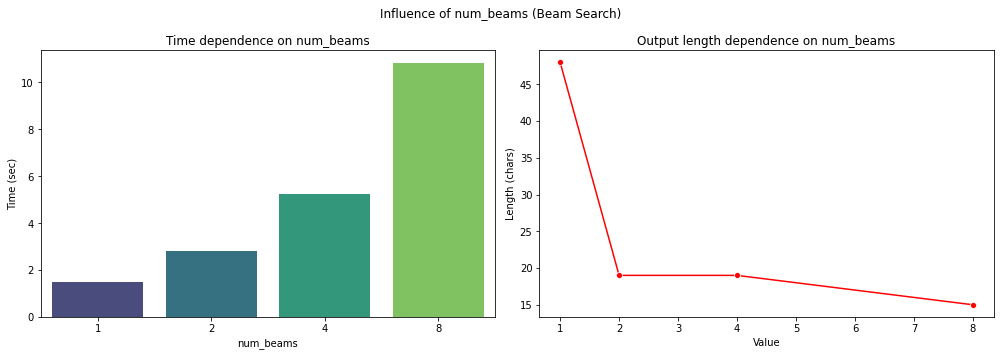

,Value,Time (sec),Output
0,1,1.4857,"Геральт поднял голову, поднял голову, поднял гол"
1,2,2.8221,Геральт не ответил.
2,4,5.2529,Геральт не ответил.
3,8,10.8336,Геральт молчал.


In [50]:
plot_results(df_beams, "Influence of num_beams (Beam Search)")

## Temperature (sampling)
do_sample=True, num_beams=1 -> Sampling

In [51]:
base_params_temp = {
    "max_new_tokens": 50,
    "num_beams": 1,
    "top_k": 0,
    "top_p": 0.0,
    "repetition_penalty": 1.0,
    "do_sample": True 
}

temp_values = [0.1, 0.5, 0.8, 1.0, 1.5, 3.0]

df_temp = benchmark_parameter("temperature", temp_values, common_prompt, base_params_temp)


Testing param: temperature


  0%|          | 0/6 [00:00<?, ?it/s]

Starting Sampling decoding.


 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]

Starting Sampling decoding.


 33%|███▎      | 2/6 [00:02<00:03,  1.07it/s]

Starting Sampling decoding.


 50%|█████     | 3/6 [00:04<00:04,  1.43s/it]

Starting Sampling decoding.


 67%|██████▋   | 4/6 [00:06<00:03,  1.70s/it]

Starting Sampling decoding.


 83%|████████▎ | 5/6 [00:08<00:01,  1.75s/it]

Starting Sampling decoding.


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


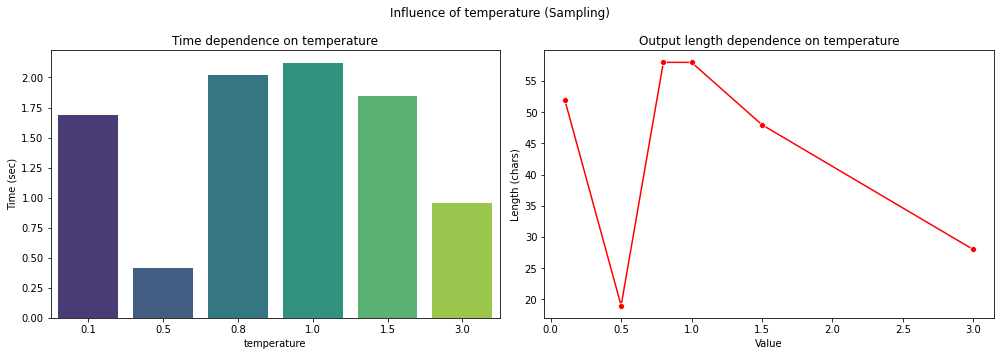

,Value,Time (sec),Output
0,0.1,1.6839,"Геральт поднял голову, поднял голову, поднял голову."
1,0.5,0.4112,Геральт не ответил.
2,0.8,2.0166,"Геральт проснулся к нему, отодвинул их. Геральт не выдержа"
3,1.0,2.1208,Геральт смолчал. Наконец заявил еще двадцать другой азель
4,1.5,1.8441,"Геральт осторожно рухнул Геральт, крепко широко."
5,3.0,0.9527,Геральт Осdегiвиыйуя КоФэ70?


In [52]:
plot_results(df_temp, "Influence of temperature (Sampling)")

## Top-K

In [53]:
base_params_k = {
    "max_new_tokens": 40,
    "num_beams": 1,
    "temperature": 1.0,
    "top_p": 0.0,
    "repetition_penalty": 1.0,
    "do_sample": True
}

k_values = [1, 5, 20, 50, 0]

df_k = benchmark_parameter("top_k", k_values, common_prompt, base_params_k)


Testing param: top_k


  0%|          | 0/5 [00:00<?, ?it/s]

Starting Sampling decoding.


 20%|██        | 1/5 [00:01<00:06,  1.74s/it]

Starting Sampling decoding.


 40%|████      | 2/5 [00:03<00:04,  1.63s/it]

Starting Sampling decoding.


 60%|██████    | 3/5 [00:04<00:03,  1.58s/it]

Starting Sampling decoding.


 80%|████████  | 4/5 [00:06<00:01,  1.58s/it]

Starting Sampling decoding.


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


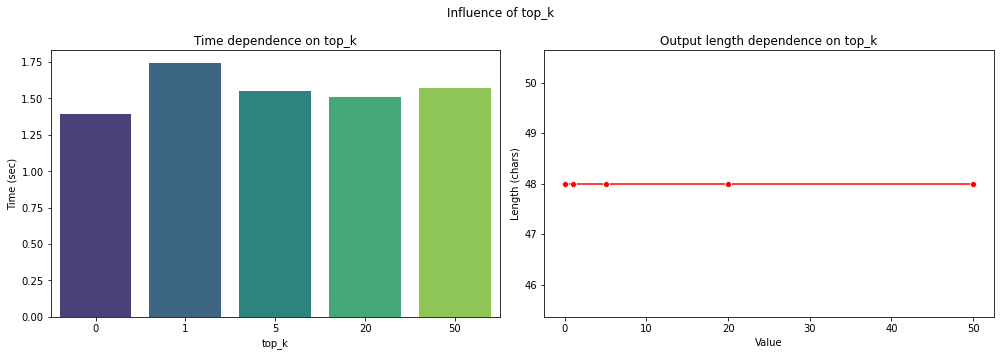

,Value,Time (sec),Output
0,1,1.7438,"Геральт поднял голову, поднял голову, поднял гол"
1,5,1.5484,"Геральт снял шапку, поправляя воду и поднял к по"
2,20,1.5114,Геральт был поздно. Господин Геральт отставил ко
3,50,1.5732,Геральт не дал слова. Пошевелил зубами. Трое при
4,0,1.3913,"Геральт выпил, вода продиктовала гремлинера, под"


In [54]:
plot_results(df_k, "Influence of top_k")

## Repetition penalty

In [55]:
loop_prompt = "Геральт из Ривии ведьмак и Геральт из Ривии"
base_params_rep = {
    "max_new_tokens": 50,
    "num_beams": 1,
    "temperature": 1.0,
    "do_sample": False, # Greedy search
    "top_k": 50,
    "top_p": 0.9,
}

penalty_values = [1.0, 1.05, 1.1, 1.2, 2.0]

df_rep = benchmark_parameter("repetition_penalty", penalty_values, loop_prompt, base_params_rep)


Testing param: repetition_penalty


  0%|          | 0/5 [00:00<?, ?it/s]

Starting Sampling decoding.


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

Starting Sampling decoding.


 80%|████████  | 4/5 [00:04<00:00,  1.19it/s]

Starting Sampling decoding.
Starting Sampling decoding.
Starting Sampling decoding.


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


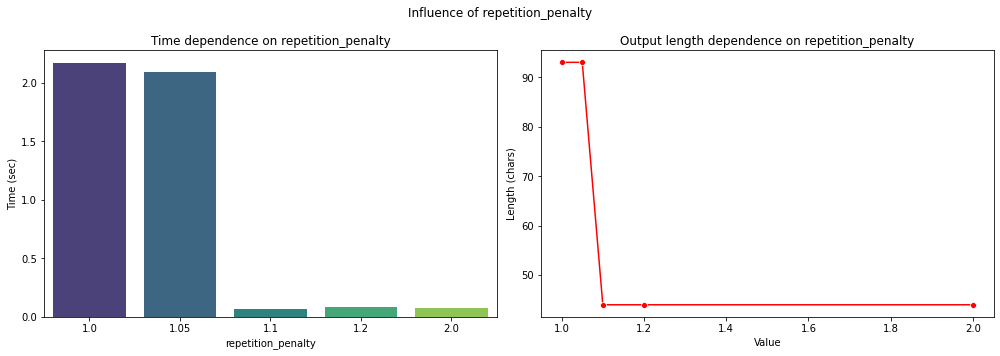

,Value,Time (sec),Output
0,1.00,2.1698,"Геральт из Ривии ведьмак и Геральт из Ривии. В этом стоял конец столба, который принял след н"
1,1.05,2.0925,Геральт из Ривии ведьмак и Геральт из Ривии. В этом стоял неподвижный столб с противоположной
2,1.10,0.0677,Геральт из Ривии ведьмак и Геральт из Ривии.
3,1.20,0.0837,Геральт из Ривии ведьмак и Геральт из Ривии.
4,2.00,0.0785,Геральт из Ривии ведьмак и Геральт из Ривии.


In [56]:
plot_results(df_rep, "Influence of repetition_penalty")

## Comparison

In [57]:
comparison_data = [
    {"Strategy": "Greedy", "Time": df_beams[df_beams['Value'] == 1]['Time (sec)'].values[0]},
    {"Strategy": "Beam Search (k=4)", "Time": df_beams[df_beams['Value'] == 4]['Time (sec)'].values[0]},
    {"Strategy": "Beam Search (k=8)", "Time": df_beams[df_beams['Value'] == 8]['Time (sec)'].values[0]},
    {"Strategy": "Sampling", "Time": df_temp[df_temp['Value'] == 1.0]['Time (sec)'].values[0]},
]

df_comp = pd.DataFrame(comparison_data)

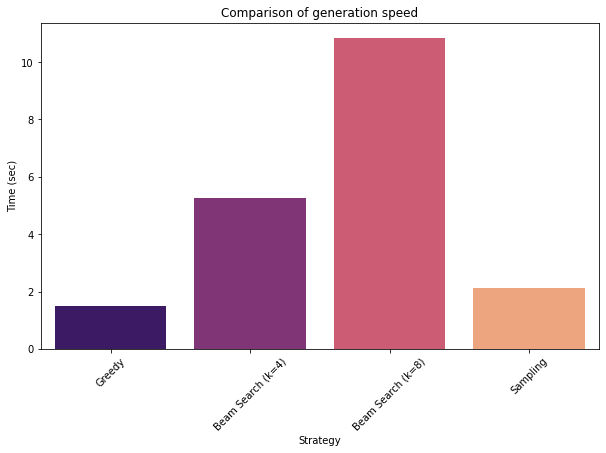

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comp, x='Strategy', y='Time', palette='magma')
plt.title('Comparison of generation speed')
plt.ylabel('Time (sec)')
plt.xticks(rotation=45)
plt.show()